# Time Series Forecasting on NYC_Taxi

w MLFlow

- Objectives
  - Leverage ML FLow to build some time series models

- Simple Forecast of aggregate daily data to start
- Later will need to look at splitting out the datasets into different spots

In [1]:
%load_ext autotime

time: 255 µs (started: 2021-07-26 12:40:05 +00:00)


In [2]:
import os
from pyspark.sql import SparkSession
packages="""io.delta:delta-core_2.12:1.0.0,org.apache.hadoop:hadoop-aws:3.2.0"""
os.environ['PYSPARK_SUBMIT_ARGS'] = "--packages io.delta:delta-core_2.12:1.0.0,org.apache.hadoop:hadoop-aws:3.2.0 pyspark-shell"

time: 84.5 ms (started: 2021-07-26 12:40:05 +00:00)


In [13]:
from pyspark.sql import functions as F
import pandas as pd

time: 433 µs (started: 2021-07-26 12:44:55 +00:00)


In [4]:
spark = SparkSession \
            .builder \
            .config("spark.executor.cores", 4) \
            .config("spark.executor.memory", "4g") \
            .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
            .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
            .config("spark.master", "spark://spark-master:7077") \
            .config("spark.hadoop.fs.s3a.access.key", os.environ['MINIO_ACCESS_KEY']) \
            .config("spark.hadoop.fs.s3a.secret.key", os.environ['MINIO_SECRET_KEY']) \
            .config("spark.hadoop.fs.s3a.endpoint", "minio:9000") \
            .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
            .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
            .config("spark.hadoop.metastore.catalog.default", "hive") \
            .config("spark.sql.warehouse.dir", "s3a://storage/warehouse") \
            .config("spark.hadoop.fs.s3a.path.style.access", "true") \
            .config("spark.hadoop.fs.s3a.connection.maximum", "50") \
            .config("spark.hive.metastore.uris", "thrift://192.168.64.4:9083") \
            .appName("Jupyter Time Series") \
            .enableHiveSupport() \
            .getOrCreate()

time: 3.11 s (started: 2021-07-26 12:40:05 +00:00)


In [5]:
# tuning settings spark.sql.shuffle.partitions to match with core settings
# not tuned for file size yet

# set to cores to increase the efficiency
spark.conf.set("spark.sql.shuffle.partitions", spark.sparkContext.defaultParallelism*4)

## faster pandas data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

time: 2.47 ms (started: 2021-07-26 12:40:08 +00:00)


In [6]:
from tseries.taxi_daily import TaxiDaily

time: 7.85 ms (started: 2021-07-26 12:40:08 +00:00)


In [7]:
taxi_daily = TaxiDaily(spark)
taxi_daily.load_data()

time: 10.5 s (started: 2021-07-26 12:40:08 +00:00)


In [8]:
taxi_daily.train_data.agg(F.min(F.col('ds')), F.max(F.col('ds'))).collect()

[Row(min(ds)=datetime.date(2013, 8, 1), max(ds)=datetime.date(2014, 6, 30))]

time: 14.6 s (started: 2021-07-26 12:40:19 +00:00)


In [9]:
taxi_daily.test_data.agg(F.min(F.col('ds')), F.max(F.col('ds'))).collect()

[Row(min(ds)=datetime.date(2014, 7, 1), max(ds)=datetime.date(2016, 6, 30))]

time: 13.4 s (started: 2021-07-26 12:40:33 +00:00)


In [10]:
train, test = taxi_daily.train_data.toPandas(), taxi_daily.test_data.toPandas()

time: 27.2 s (started: 2021-07-26 12:40:47 +00:00)


In [34]:
train_sktime = pd.Series(data=train['y'].values, index=pd.to_datetime(train['ds']))
test_sktime = pd.Series(data=test['y'].values, index=pd.to_datetime(test['ds']))

time: 2.48 ms (started: 2021-07-26 12:50:08 +00:00)


# Settings for MLflow

In [10]:
# credentials for storing our model artifacts
# mlflow needs these to be set whenever it is being called
os.environ['AWS_ACCESS_KEY_ID'] = os.environ.get('MINIO_ACCESS_KEY')
os.environ['AWS_SECRET_ACCESS_KEY'] = os.environ.get('MINIO_SECRET_KEY')
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://minio:9000'

time: 432 µs (started: 2021-07-26 11:28:39 +00:00)


## Forecasting the Dataframe

In [11]:
import prophet
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import mlflow

time: 2.29 s (started: 2021-07-26 11:28:39 +00:00)


There was an error in the hostname resolution hence switch to ip

In [12]:
#mlflow.delete_experiment(1)

time: 133 µs (started: 2021-07-26 11:28:41 +00:00)


In [13]:
mlflow.set_tracking_uri("http://192.168.64.21:5000/")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://192.168.64.21:5000/
time: 6.81 ms (started: 2021-07-26 11:28:41 +00:00)


In [14]:
### Quick test on creating experiments
from mlflow.exceptions import RestException

try:
    mlflow.create_experiment(
        name='taxi_daily_forecast'
    )
except RestException:
    print('already_created')

already_created
time: 689 ms (started: 2021-07-26 11:28:41 +00:00)


In [15]:
experiment = mlflow.get_experiment(15)
experiment.artifact_location

's3://mlflow/15'

time: 239 ms (started: 2021-07-26 11:28:42 +00:00)


In [16]:
# Build an evaluation function
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

time: 329 ms (started: 2021-07-26 11:28:42 +00:00)


In [17]:
# To save models to mlflow we need to write a python wrapper 
# to make sure that it performs as mlflow expects
import mlflow.pyfunc

class ProphetModel(mlflow.pyfunc.PythonModel):
    
    def __init__(self, model):
        
        self.model = model
        super().__init__()
        
    def load_context(self, context):
        from prophet import Prophet
        return
    
    def predict(self, context, model_input):
        future = self.model.make_future_dataframe(periods=model_input['periods'][0])
        return self.model.predict(future)

time: 548 µs (started: 2021-07-26 11:28:42 +00:00)


44 seconds for training by default \
3.62 seconds with processes parallelisation \
13 seconds after we add the toPandas conversion here and run with parallelisation

In [18]:
%time

rolling_window = 0.1

conda_env = {
    'channels': ['conda-forge'],
    'dependencies': [{
        'pip': [
            'prophet=={0}'.format(prophet.__version__)
        ]
    }],
    "name": "prophetenv"
}

with mlflow.start_run(experiment_id=15):
    m = prophet.Prophet(daily_seasonality=True)
    m.fit(taxi_daily.train_data.toPandas())
    
    # cross validation is the thingy that is generating our different train sets
    # tqdm is glitchy with my setup so disabling for now
    df_cv = cross_validation(m, initial="28 days", period="7 days", horizon="14 days", 
                                 disable_tqdm=True, parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=rolling_window)
    
    mlflow.log_param("rolling_window", rolling_window)
    mlflow.log_metric("rmse", df_p.loc[0, "rmse"])
    mlflow.log_metric("mae", df_p.loc[0, "mae"])
    mlflow.log_metric("mape", df_p.loc[0, "mape"])
    
    print("  CV: {}".format(df_cv.head()))
    print("  Perf: {}".format(df_p.head()))
    
    mlflow.pyfunc.log_model("model", conda_env=conda_env, python_model=ProphetModel(m))
    print(
            "Logged model with URI: runs:/{run_id}/model".format(
                run_id=mlflow.active_run().info.run_id
            )
        )

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Making 42 forecasts with cutoffs between 2013-09-02 00:00:00 and 2014-06-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8c8b86efa0>
INFO:botocore.credentials:Found credentials in environment variables.


  CV:           ds           yhat     yhat_lower     yhat_upper       y     cutoff
0 2013-09-03  501585.281837  425486.565932  578429.345631  423109 2013-09-02
1 2013-09-04  518817.592943  442524.599489  590208.008164  454753 2013-09-02
2 2013-09-05  504761.734693  426917.204382  576432.929116  468204 2013-09-02
3 2013-09-06  495324.421080  416555.478951  571023.477450  509666 2013-09-02
4 2013-09-07  474445.011476  403222.291631  548072.581577  512373 2013-09-02
  Perf:   horizon           mse          rmse           mae      mape     mdape  \
0  2 days  2.802909e+09  52942.502951  37278.418974  0.086742  0.049990   
1  3 days  3.124219e+09  55894.709955  37167.961699  0.085093  0.047995   
2  4 days  3.170948e+09  56311.167889  37426.567206  0.081971  0.043602   
3  5 days  2.723070e+09  52183.046660  38084.927978  0.074821  0.056177   
4  6 days  1.912054e+09  43727.040544  33739.912505  0.068865  0.045557   

      smape  coverage  
0  0.078420  0.908867  
1  0.077513  0.894089  
2

# Prophet Diagnostics

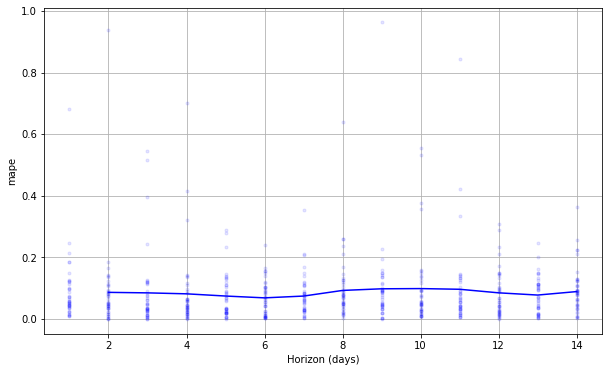

time: 105 ms (started: 2021-07-26 11:29:01 +00:00)


In [19]:
# Python
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

We aren't seeing many differences with longer horizons

In [20]:
future = m.make_future_dataframe(periods=len(taxi_daily.test_data.toPandas()))

time: 15.1 s (started: 2021-07-26 11:29:01 +00:00)


In [21]:
forecast = m.predict(future)

time: 2.49 s (started: 2021-07-26 11:29:16 +00:00)


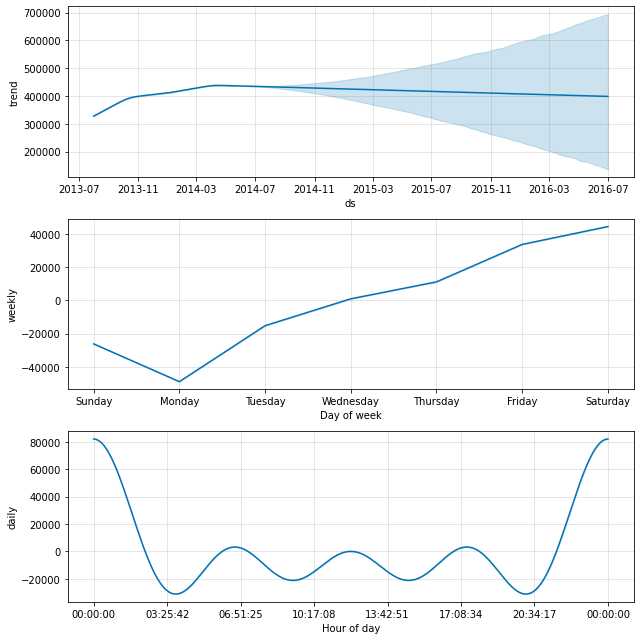

time: 303 ms (started: 2021-07-26 11:29:18 +00:00)


In [22]:
fig = m.plot_components(forecast)

# Testing out Uber Orbit

In [23]:
from orbit.models.dlt import DLTFull
from orbit.diagnostics.plot import plot_predicted_data

time: 631 ms (started: 2021-07-26 11:29:19 +00:00)


In [24]:
dlt = DLTFull(
    response_col='y', date_col='ds',
    #regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=7,
)

time: 394 µs (started: 2021-07-26 11:29:19 +00:00)


In [25]:
dlt.fit(df=taxi_daily.train_data.toPandas())

# outcomes data frame
predicted_df = dlt.predict(df=taxi_daily.test_data.toPandas())

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


time: 30.7 s (started: 2021-07-26 11:29:19 +00:00)


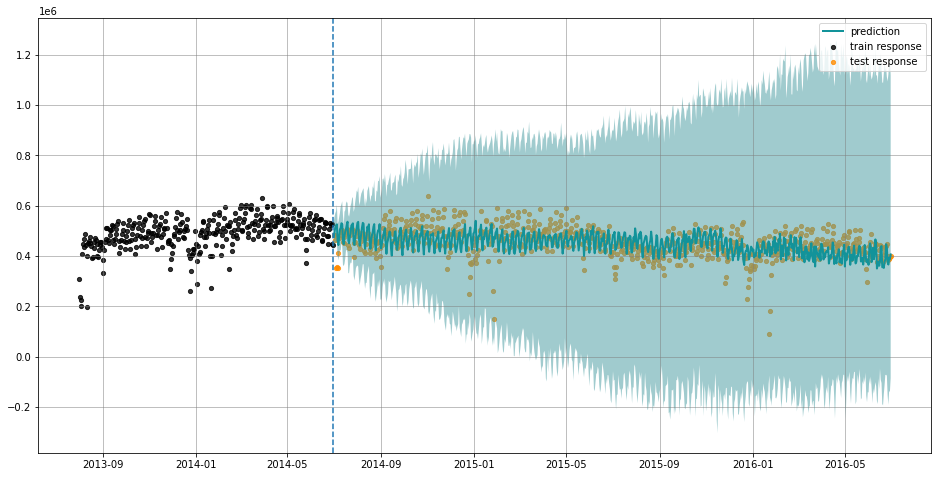

<AxesSubplot:>

time: 28.1 s (started: 2021-07-26 11:29:50 +00:00)


In [26]:
plot_predicted_data(
    training_actual_df=taxi_daily.train_data.toPandas(), predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=taxi_daily.test_data.toPandas()
)

# Testing sktime

In [72]:
from sktime.utils.plotting import plot_series
import numpy as np

time: 420 µs (started: 2021-07-26 13:44:20 +00:00)


In [79]:
test_sktime

ds
2014-07-01    483965
2014-07-02    481947
2014-07-03    463557
2014-07-04    351243
2014-07-05    355231
               ...  
2016-06-26    383165
2016-06-27    398591
2016-06-28    386237
2016-06-29    395293
2016-06-30    400676
Length: 731, dtype: int64

time: 4.02 ms (started: 2021-07-26 14:07:40 +00:00)


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

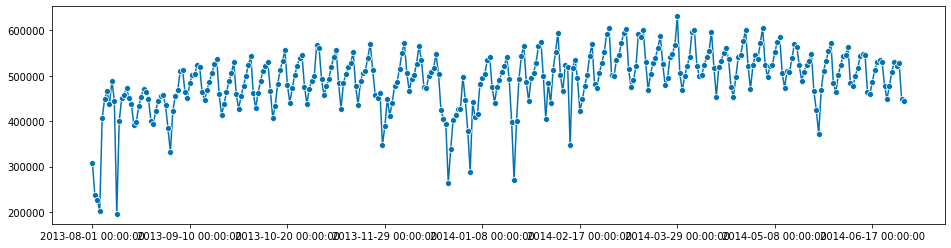

time: 133 ms (started: 2021-07-26 12:50:13 +00:00)


In [35]:
plot_series(train_sktime)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

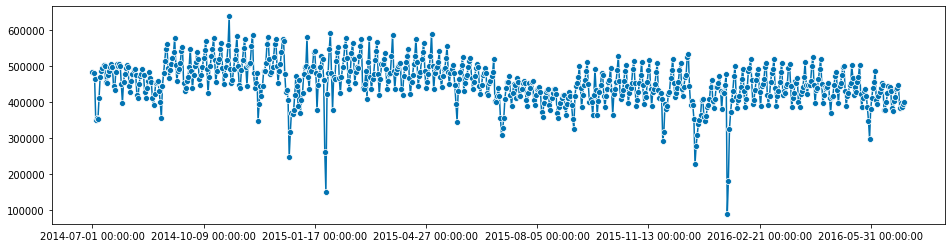

time: 144 ms (started: 2021-07-26 12:50:25 +00:00)


In [36]:
plot_series(test_sktime)

In [67]:
from sktime.forecasting.model_selection import temporal_train_test_split

time: 412 µs (started: 2021-07-26 13:37:11 +00:00)


In [52]:
test_sktime.index[0]
len(test_sktime.index)
max(test_sktime.index)

Timestamp('2016-06-30 00:00:00')

time: 3.18 ms (started: 2021-07-26 13:03:33 +00:00)


In [51]:
# test pandas
#pd.PeriodIndex(pd.date_range("2020-01-01", periods=30, freq="D"))
from sktime.forecasting.base import ForecastingHorizon

#fh = ForecastingHorizon(test_sktime.index, is_relative=False)
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range(test_sktime.index[0], 
                                 periods=len(test_sktime.index), 
                                 freq="D")), is_relative=False
)

fh

ForecastingHorizon(['2014-07-01', '2014-07-02', '2014-07-03', '2014-07-04',
             '2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
             '2014-07-09', '2014-07-10',
             ...
             '2016-06-21', '2016-06-22', '2016-06-23', '2016-06-24',
             '2016-06-25', '2016-06-26', '2016-06-27', '2016-06-28',
             '2016-06-29', '2016-06-30'],
            dtype='period[D]', length=731, freq='D', is_relative=False)

time: 4.28 ms (started: 2021-07-26 13:03:21 +00:00)


In [68]:
#cutoff = pd.Period(max(test_sktime.index), freq="D")
#fh.to_absolute(cutoff)

time: 301 µs (started: 2021-07-26 13:41:32 +00:00)


In [69]:
from sktime.forecasting.naive import NaiveForecaster

basic_forecaster =  NaiveForecaster(strategy="last")
forecaster = NaiveForecaster(strategy="last")

time: 521 µs (started: 2021-07-26 13:41:36 +00:00)


In [71]:
forecaster.fit(train_sktime)

NaiveForecaster()

time: 2.91 ms (started: 2021-07-26 13:41:51 +00:00)


In [80]:
# stuck here for now
#forecaster.predict(fh)

AssertionError: 

time: 12.3 ms (started: 2021-07-26 14:10:26 +00:00)


## Stopping Spark Session

In [27]:
spark.stop()

time: 442 ms (started: 2021-07-26 11:30:18 +00:00)
